<a href="https://colab.research.google.com/github/JaredRob/TrackData/blob/main/Behaviour_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
!git clone https://github.com/JaredRob/TrackData

fatal: destination path 'TrackData' already exists and is not an empty directory.


In [108]:
!ls TrackData

driving_log.csv  IMG


In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath

In [110]:
datadir = 'TrackData'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_397.jpg,C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_397.jpg,C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_397.jpg,0.0,0.0,0,0.000078
1,C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_498.jpg,C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_498.jpg,C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_498.jpg,0.0,0.0,0,0.000078
2,C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_603.jpg,C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_603.jpg,C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_603.jpg,0.0,0.0,0,0.000081
3,C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_703.jpg,C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_703.jpg,C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_703.jpg,0.0,0.0,0,0.000080
4,C:\Users\Jared\Desktop\Data\IMG\center_2022_10_31_21_11_18_810.jpg,C:\Users\Jared\Desktop\Data\IMG\left_2022_10_31_21_11_18_810.jpg,C:\Users\Jared\Desktop\Data\IMG\right_2022_10_31_21_11_18_810.jpg,0.0,0.0,0,0.000078


In [111]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_10_31_21_11_18_397.jpg,left_2022_10_31_21_11_18_397.jpg,right_2022_10_31_21_11_18_397.jpg,0.0,0.0,0,0.000078
1,center_2022_10_31_21_11_18_498.jpg,left_2022_10_31_21_11_18_498.jpg,right_2022_10_31_21_11_18_498.jpg,0.0,0.0,0,0.000078
2,center_2022_10_31_21_11_18_603.jpg,left_2022_10_31_21_11_18_603.jpg,right_2022_10_31_21_11_18_603.jpg,0.0,0.0,0,0.000081
3,center_2022_10_31_21_11_18_703.jpg,left_2022_10_31_21_11_18_703.jpg,right_2022_10_31_21_11_18_703.jpg,0.0,0.0,0,0.000080
4,center_2022_10_31_21_11_18_810.jpg,left_2022_10_31_21_11_18_810.jpg,right_2022_10_31_21_11_18_810.jpg,0.0,0.0,0,0.000078


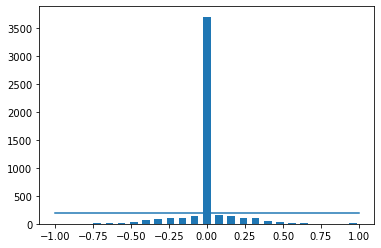

In [112]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data 4893
removed: 3505
remaining data:  1388


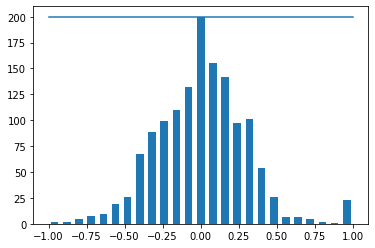

In [113]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [114]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


In [115]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1110
Valid Samples: 278


Text(0.5, 1.0, 'Validation set')

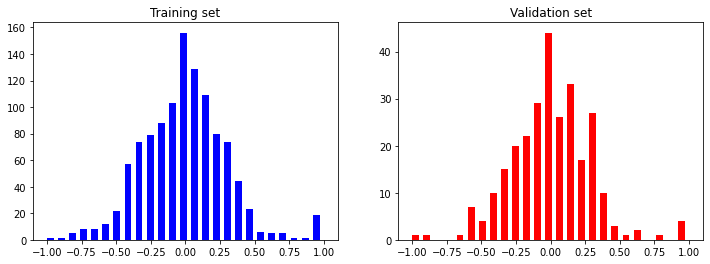

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [117]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed image')

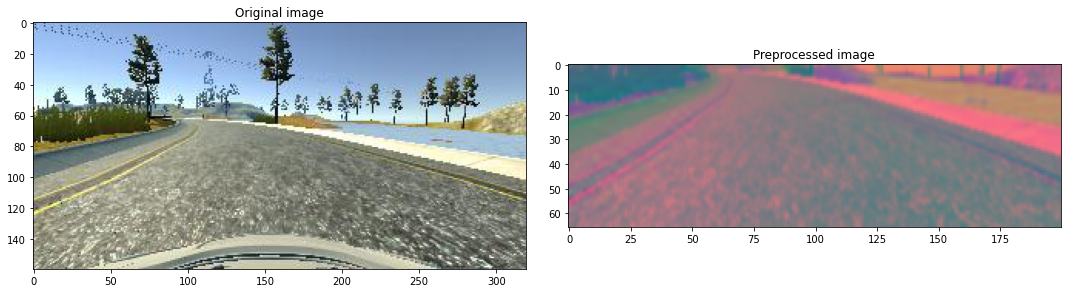

In [118]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [119]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1110, 66, 200, 3)


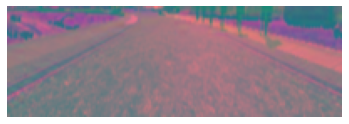

In [120]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [121]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, 5, strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
    
    model.add(Conv2D(36, 5, strides=(2,2), activation='elu'))
    model.add(Conv2D(48, 5, strides=(2,2), activation='elu'))
    model.add(Conv2D(64, 3, activation='elu'))
    model.add(Conv2D(64, 3, activation='elu'))
    model.add(Dropout(0.5))
    
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    
    
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation ='elu'))
    model.add(Dense(1))
    
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [122]:
model = nvidia_model()
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_36 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_38 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_39 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_14 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_7 (Flatten)         (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [123]:
history = model.fit(x = X_train, y = y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
12/12 [==============================] - 10s 740ms/step - loss: 0.7838 - val_loss: 0.0844
Epoch 2/30
12/12 [==============================] - 8s 708ms/step - loss: 0.1256 - val_loss: 0.0870
Epoch 3/30
12/12 [==============================] - 8s 701ms/step - loss: 0.1124 - val_loss: 0.1066
Epoch 4/30
12/12 [==============================] - 8s 706ms/step - loss: 0.1151 - val_loss: 0.0849
Epoch 5/30
12/12 [==============================] - 9s 710ms/step - loss: 0.0977 - val_loss: 0.0842
Epoch 6/30
12/12 [==============================] - 9s 712ms/step - loss: 0.0955 - val_loss: 0.0787
Epoch 7/30
12/12 [==============================] - 9s 723ms/step - loss: 0.0901 - val_loss: 0.0728
Epoch 8/30
12/12 [==============================] - 8s 707ms/step - loss: 0.0833 - val_loss: 0.0695
Epoch 9/30
12/12 [==============================] - 8s 703ms/step - loss: 0.0801 - val_loss: 0.0810
Epoch 10/30
12/12 [==============================] - 8s 704ms/step - loss: 0.0749 - val_loss: 0.063

Text(0.5, 0, 'Epoch')

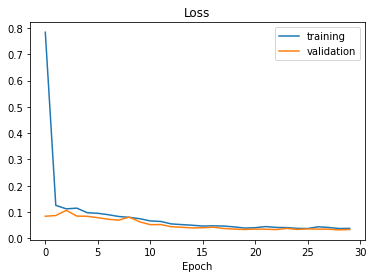

In [124]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')